<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

# Pyosim in the cloud
## with [pyomeca](https://github.com/pyomeca/pyomeca)
Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Analyses](02.00-analyses.ipynb) | [Contents](Index.ipynb) |

# Activations

In [1]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt
from pyosim import Conf
from pyomeca import Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import parse_conditions, condition_counter, random_balanced_design, get_spm_cluster

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

In [3]:
aws_conf = yaml.safe_load(open("../conf.yml"))

conf = Conf(project_path=aws_conf["path"]["project"]["local"])
participants = conf.get_participants_to_process()
conf.check_confs()

Project loaded
Configuration file loaded


## Reading files

In [4]:
act = (
    pd.concat(
        [
            Analogs3d.from_sto(ifile)
            .time_normalization()
            .to_dataframe()
            .assign(filename=ifile.stem)
            for ifile in conf.project_path.glob(
                "*/3_static_optimization/*activation.sto"
            )
        ]
    )
    .pipe(parse_conditions, suffix="wu_", prefix="_StaticOptimization_activation")
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("weight != 18")
)

act.head()

,index,LVS,TRP1,TRP2,TRP3,TRP4,RMN,RMJ1,RMJ2,SRA1,...,AC3,GH1,GH2,GH3,filename,participant,men,height,weight,n_trial
0,0.00,0.093195,0.194355,0.083498,0.055261,0.045271,0.105586,0.029389,0.010329,0.066250,...,0.008311,-0.026867,0.022399,0.020511,VerCF12H2_3,verc,0,2,12,3
1,0.01,0.129131,0.309957,0.134745,0.094603,0.057375,0.152283,0.032945,0.010123,0.011763,...,0.014365,-0.036946,0.028573,0.033740,VerCF12H2_3,verc,0,2,12,3
2,0.02,0.203825,0.365121,0.189626,0.139795,0.095451,0.228780,0.037695,0.010086,0.010040,...,0.026711,-0.051659,0.038459,0.049153,VerCF12H2_3,verc,0,2,12,3
3,0.03,0.327648,0.479070,0.278189,0.204747,0.171899,0.349120,0.051687,0.010075,0.010031,...,0.044441,-0.076361,0.055289,0.071399,VerCF12H2_3,verc,0,2,12,3
4,0.04,0.396332,0.566834,0.359928,0.260211,0.224858,0.410618,0.050651,0.010039,0.010029,...,0.057666,-0.097264,0.071052,0.086335,VerCF12H2_3,verc,0,2,12,3


## Clean data

### Balance dataset

In [5]:
condition_counter(act)

n. participants: 33
----------
participant
aimq    6
aleb    6
alef    6
ameg    6
amia    6
anns    4
camb    6
dapo    6
davo    5
doca    6
eved    6
fabd    5
gabf    6
geoa    6
inea    5
jawr    5
karm    6
laug    6
marh    6
mars    6
matr    6
naus    6
nemk    4
noel    6
romm    6
roxd    6
samn    6
sarc    6
steb    5
sylg    6
verc    6
yoab    6
yoap    5
----------
men
0    110
1     78
----------
height
2    188
----------
weight
6     95
12    93
----------
men  weight
0    6         54
     12        56
1    6         41
     12        37
----------


In [6]:
balanced_trials = random_balanced_design(
    act, ["men", "weight"], random_state=RANDOM_SEED
)
act = act.query("filename == @balanced_trials")
condition_counter(act)

n. participants: 33
----------
participant
aimq    2
aleb    6
alef    6
ameg    3
amia    2
anns    3
camb    5
dapo    4
davo    5
doca    6
eved    3
fabd    5
gabf    4
geoa    6
inea    3
jawr    5
karm    5
laug    6
marh    4
mars    5
matr    6
naus    4
nemk    3
noel    6
romm    6
roxd    4
samn    1
sarc    4
steb    3
sylg    6
verc    6
yoab    6
yoap    5
----------
men
0    74
1    74
----------
height
2    148
----------
weight
6     74
12    74
----------
men  weight
0    6         37
     12        37
1    6         37
     12        37
----------


### Remove unwanted variables

In [7]:
id_vars = ["filename", "participant", "men", "height", "weight", "n_trial", "index"]
act_melt = act.melt(id_vars=id_vars)
act_melt.head()

,filename,participant,men,height,weight,n_trial,index,variable,value
0,VerCF12H2_3,verc,0,2,12,3,0.00,LVS,0.093195
1,VerCF12H2_3,verc,0,2,12,3,0.01,LVS,0.129131
2,VerCF12H2_3,verc,0,2,12,3,0.02,LVS,0.203825
3,VerCF12H2_3,verc,0,2,12,3,0.03,LVS,0.327648
4,VerCF12H2_3,verc,0,2,12,3,0.04,LVS,0.396332


In [8]:
blacklist = ["AC1", "AC2", "AC3", "SC1", "SC2", "SC3", "GH1", "GH2", "GH3"]
blacklist = blacklist + [
    "box_Rx",
    "box_Ry",
    "box_Rz",
    "box_Tx",
    "box_Ty",
    "box_Tz",
    "thorax_Tx",
    "thorax_Ty",
    "thorax_Tz",
    "thorax_Rx",
    "thorax_Ry",
    "thorax_Rz",
    "elbow_Rz",
    "elbow_Ry",
    "hand_Rz",
    "hand_Rx",
]

act_melt = act_melt.query("variable != @blacklist")

In [9]:
print(
    f"value == 1.00 --> {act_melt.query('value == 1.0').shape[0] / act_melt.shape[0] * 100:.2f}%"
)

value == 1.00 --> 1.82%


## $\sum\text{activation}$

In [10]:
sum_act = act_melt.groupby(id_vars)["value"].sum().reset_index()
sum_act.head()

,filename,participant,men,height,weight,n_trial,index,value
0,AimQF12H2_2,aimq,0,2,12,2,0.00,2.019726
1,AimQF12H2_2,aimq,0,2,12,2,0.01,1.720067
2,AimQF12H2_2,aimq,0,2,12,2,0.02,1.252395
3,AimQF12H2_2,aimq,0,2,12,2,0.03,1.053381
4,AimQF12H2_2,aimq,0,2,12,2,0.04,0.970690


In [11]:
base = alt.Chart().encode(
    alt.X("index", title="normalized trial", axis=alt.Axis(format="%"))
)
mu = base.mark_line().encode(alt.Y("mean(value)", title="activation"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))

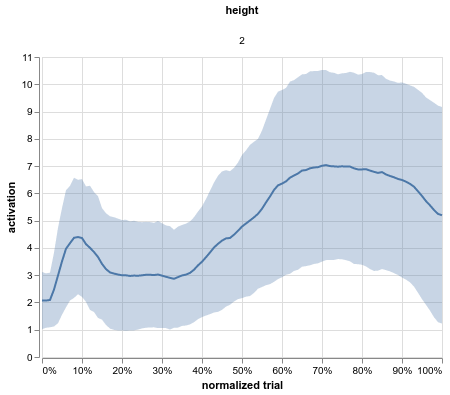

In [12]:
(mu + sigma).facet(data=sum_act, column="height")

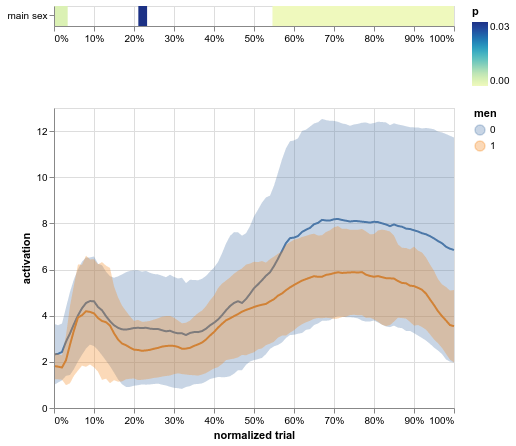

In [46]:
effect = (
    alt.Chart(clusters)
    .mark_rect()
    .encode(
        alt.X("start", axis=alt.Axis(format="%"), title=None),
        alt.X2("end"),
        alt.Y("effect", title=None),
        alt.Color("p"),
    )
)

base = alt.Chart(sum_act).encode(
    alt.X("index", title="normalized trial", axis=alt.Axis(format="%")),
    alt.Color("men:N"),
)
mu = base.mark_line().encode(alt.Y("mean(value)", title="activation"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))

effect.transform_filter('datum.effect == "main sex"') & (mu + sigma)

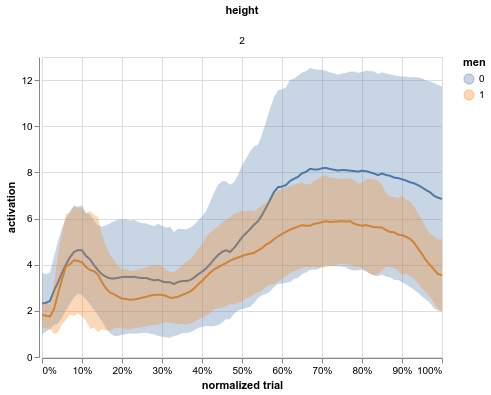

In [37]:
(mu + sigma).encode(alt.Color("men:N")).facet(data=sum_act, column="height")

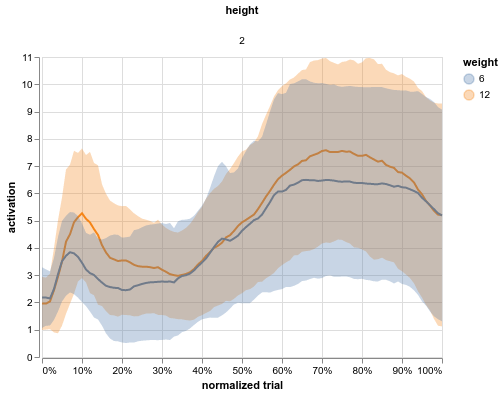

In [23]:
(mu + sigma).encode(alt.Color("weight:N")).facet(data=sum_act, column="height")

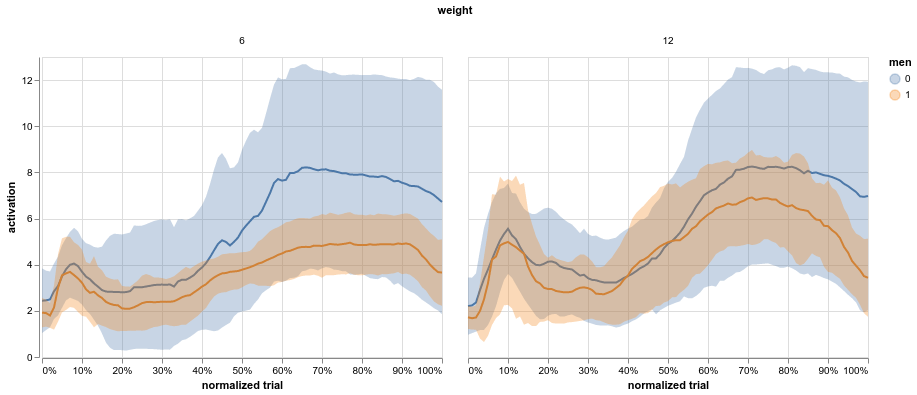

In [15]:
(mu + sigma).encode(alt.Color("men:N")).facet(data=sum_act, column="weight")

In [16]:
y = (
    sum_act.assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index(id_vars)
    .unstack()
)
y.head()

value            \
index                                                  0.00      0.01   
filename    participant men height weight n_trial                       
AimQF12H2_2 0           0   2      12     2        2.019726  1.720067   
AimQF6H2_1  0           0   2      6      1        1.693866  1.698144   
AleBH12H2_1 1           1   2      12     1        1.383623  1.287978   
AleBH12H2_2 1           1   2      12     2        1.749704  1.423249   
AleBH12H2_3 1           1   2      12     3        1.245111  1.011298   

                                                                       \
index                                                  0.02      0.03   
filename    participant men height weight n_trial                       
AimQF12H2_2 0           0   2      12     2        1.252395  1.053381   
AimQF6H2_1  0           0   2      6      1        1.745023  3.007067   
AleBH12H2_1 1           1   2      12     1        1.214561  1.680218   
AleBH12H2_2 1           1   2      12     2        1.970733  2.097811   
AleBH12H2_3 1           1   2      12     3        1.043485  1.130021   

                                                                       \
index                                                  0.04      0.05   
filename    participant men height weight n_trial                       
AimQF12H2_2 0           0   2      12     2        0.970690  1.160973   
AimQF6H2_1  0           0   2      6      1        3.615265  3.720659   
AleBH12H2_1 1           1   2      12     1        2.171147  2.603659   
AleBH12H2_2 1           1   2      12     2        2.281869  3.941715   
AleBH12H2_3 1           1   2      12     3        1.478112  1.824692   

                                                                       \
index                                                  0.06      0.07   
filename    participant men height weight n_trial                       
AimQF12H2_2 0           0   2      12     2        1.382121  1.292042   
AimQF6H2_1  0           0   2      6      1        3.750753  3.732351   
AleBH12H2_1 1           1   2      12     1        3.444003  4.906679   
AleBH12H2_2 1           1   2      12     2        6.740109  7.658256   
AleBH12H2_3 1           1   2      12     3        2.952150  4.850765   

                                                                       ...  \
index                                                  0.08      0.09  ...   
filename    participant men height weight n_trial                      ...   
AimQF12H2_2 0           0   2      12     2        2.596440  5.654903  ...   
AimQF6H2_1  0           0   2      6      1        3.501193  3.332644  ...   
AleBH12H2_1 1           1   2      12     1        6.338339  7.200557  ...   
AleBH12H2_2 1           1   2      12     2        7.454248  6.498545  ...   
AleBH12H2_3 1           1   2      12     3        6.806694  7.234773  ...   

                                                                       \
index                                                  0.91      0.92   
filename    participant men height weight n_trial                       
AimQF12H2_2 0           0   2      12     2        6.147710  6.002689   
AimQF6H2_1  0           0   2      6      1        3.646579  2.990601   
AleBH12H2_1 1           1   2      12     1        8.063664  8.104391   
AleBH12H2_2 1           1   2      12     2        6.705364  6.878920   
AleBH12H2_3 1           1   2      12     3        6.923374  6.870753   

                                                                       \
index                                                  0.93      0.94   
filename    participant men height weight n_trial                       
AimQF12H2_2 0           0   2      12     2        4.919254  4.048877   
AimQF6H2_1  0           0   2      6      1        2.989856  2.517842   
AleBH12H2_1 1           1   2      12     1        7.935008  7.841642   
AleBH12H2_2 1           1   2      12     2        7.011081  7.116

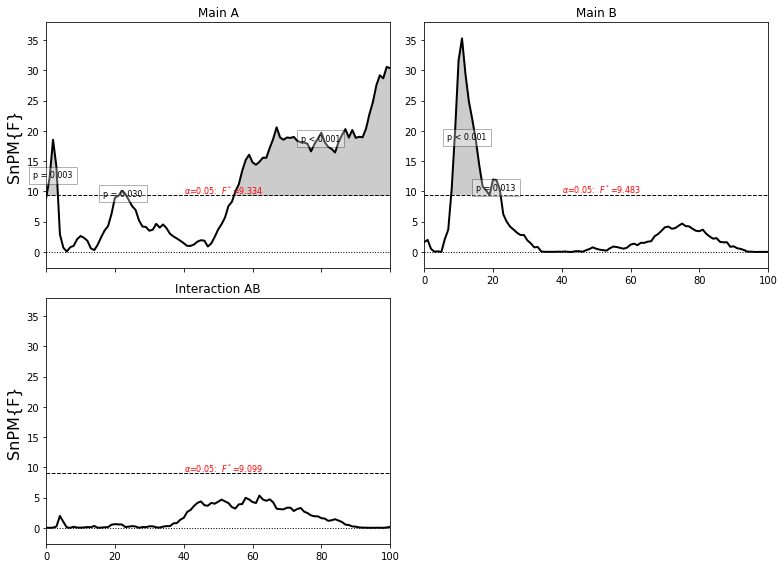

In [17]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(),
    A=y.index.get_level_values("men"),
    B=y.index.get_level_values("weight"),
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [26]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main sex",
        "Main B": "main mass",
        "Interaction AB": "interaction sex-mass",
    },
    mult=0.01,
)
clusters

,effect,p,start,end
0,main sex,0.003,0.00118633,0.0342149
1,main sex,0.0303333,0.210851,0.232742
2,main sex,0,0.546159,1
3,main mass,0.000333333,0.0785577,0.188821
4,main mass,0.0126667,0.190357,0.221991


In [25]:
100 * 0.01

1.0

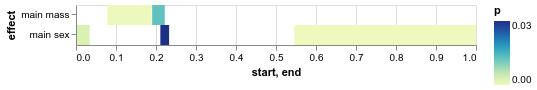

In [27]:
alt.Chart(clusters).mark_rect().encode(
    alt.X("start"), alt.X2("end"), alt.Y("effect"), alt.Color("p")
)

## ECDF

### ECDF on activations

In [12]:
act_melt["ecdf"] = act_melt.groupby("filename")["value"].transform(
    lambda x: x.rank(method="first") / x.shape[0]
)

In [13]:
base = alt.Chart().encode(alt.X("ecdf", axis=alt.Axis(format="%")))
mu = base.mark_line().encode(alt.Y("mean(value)"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value"))

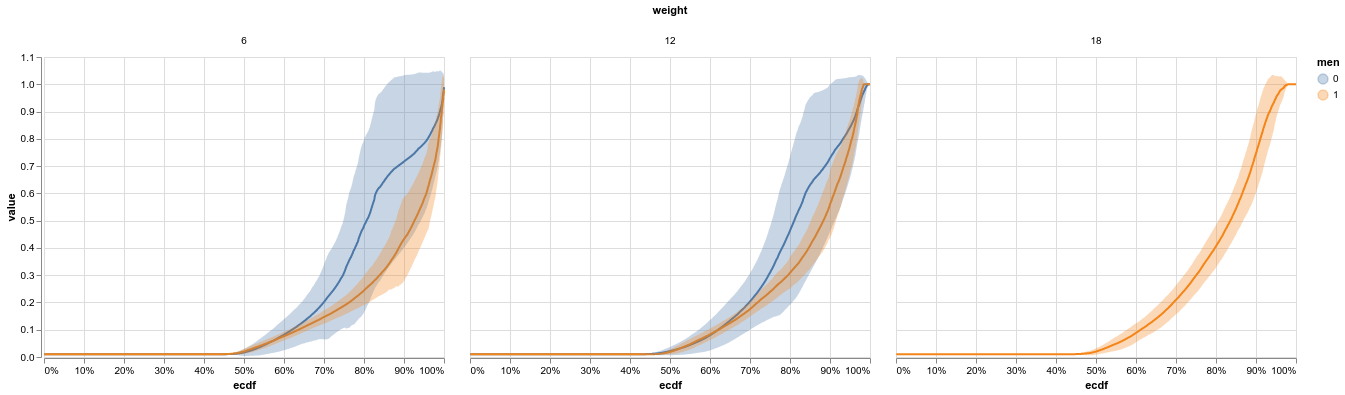

In [14]:
(mu + sigma).encode(alt.Color("men:N")).facet(data=act_melt, column="weight")

### ECDF on $\sum\text{activations}$

In [17]:
sum_act["ecdf"] = sum_act.groupby("filename")["value"].transform(
    lambda x: x.rank(method="first") / x.shape[0]
)
sum_act.head()

,filename,participant,men,height,weight,n_trial,index,value,ecdf
0,AimQF12H2_1,aimq,0,2,12,1,0.00,1.695294,0.178218
1,AimQF12H2_1,aimq,0,2,12,1,0.01,1.409868,0.128713
2,AimQF12H2_1,aimq,0,2,12,1,0.02,1.289427,0.059406
3,AimQF12H2_1,aimq,0,2,12,1,0.03,1.375817,0.099010
4,AimQF12H2_1,aimq,0,2,12,1,0.04,1.737254,0.198020


In [18]:
base = alt.Chart().encode(alt.X("ecdf", axis=alt.Axis(format="%")))
mu = base.mark_line().encode(alt.Y("mean(value)"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value"))

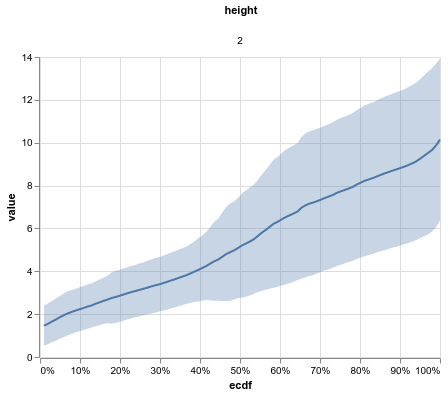

In [19]:
(mu + sigma).facet(data=sum_act, column="height")

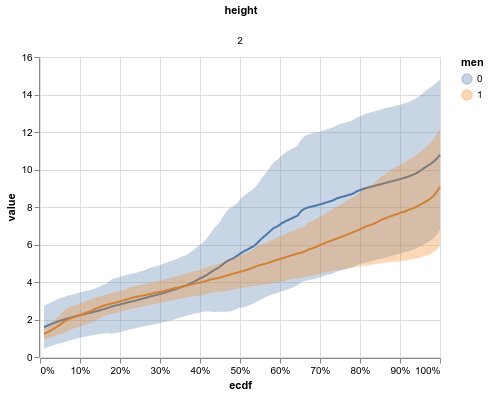

In [20]:
(mu + sigma).encode(alt.Color("men:N")).facet(data=sum_act, column="height")

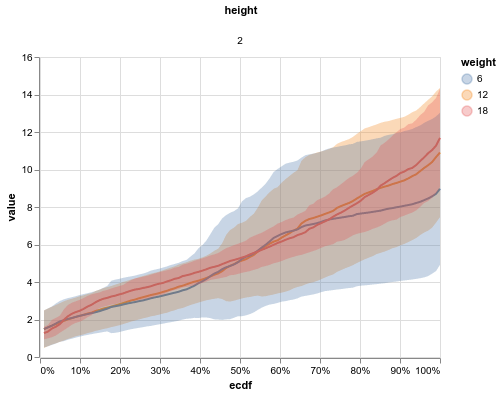

In [21]:
(mu + sigma).encode(alt.Color("weight:N")).facet(data=sum_act, column="height")

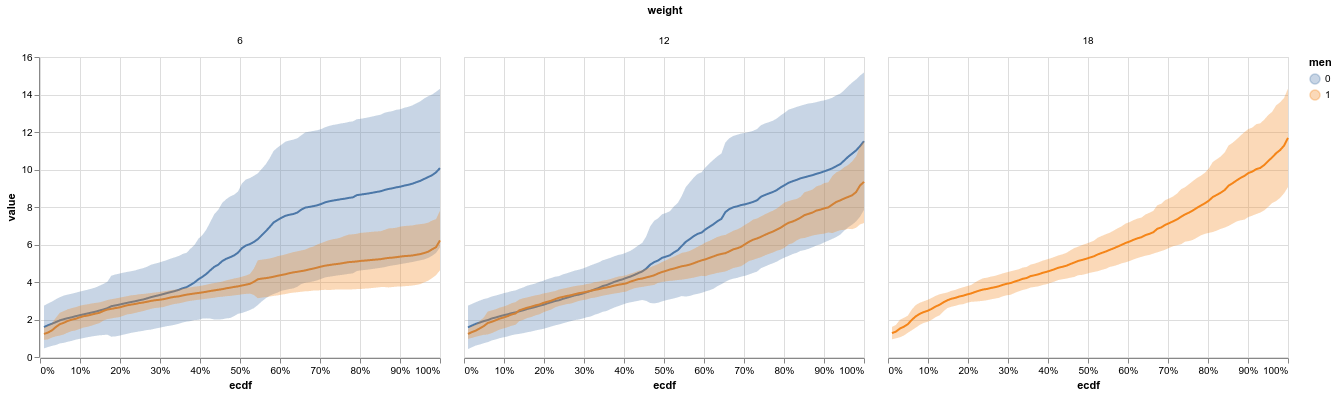

In [22]:
(mu + sigma).encode(alt.Color("men:N")).facet(data=sum_act, column="weight")

## $\sum\sum\text{activations}$

In [15]:
sum_sum_act = (
    sum_act.groupby([i for i in id_vars if i != "index"])["value"].sum().reset_index()
)
sum_sum_act.head()

,filename,participant,men,height,weight,n_trial,value
0,AimQF12H2_1,aimq,0,2,12,1,367.091902
1,AimQF12H2_2,aimq,0,2,12,2,341.375770
2,AimQF12H2_3,aimq,0,2,12,3,324.537444
3,AimQF6H2_1,aimq,0,2,6,1,351.786640
4,AimQF6H2_2,aimq,0,2,6,2,548.178460


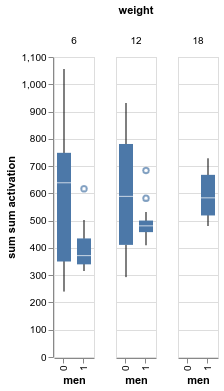

In [27]:
alt.Chart().mark_boxplot().encode(
    alt.X("men:N"), alt.Y("value", title="sum sum activation")
).facet(data=sum_sum_act, column=alt.Column("weight"))

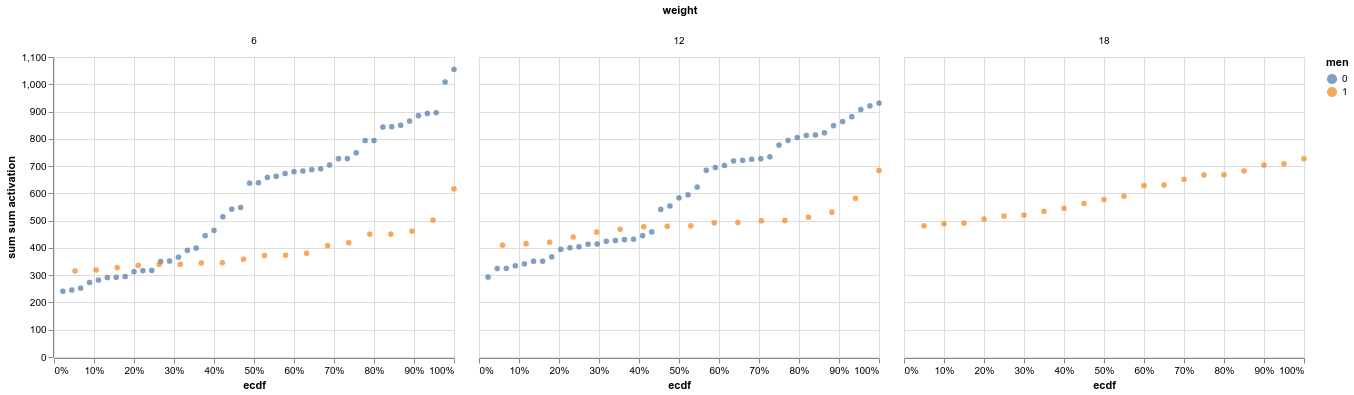

In [26]:
alt.Chart(
    sum_sum_act.assign(
        ecdf=lambda x: x.groupby(["men", "weight"])["value"].transform(
            lambda x: x.rank(method="first") / x.shape[0]
        )
    )
).mark_circle().encode(
    alt.X("ecdf", axis=alt.Axis(format="%")),
    alt.Y("value", title="sum sum activation"),
    alt.Color("men:N"),
    alt.Column("weight"),
)

<!--NAVIGATION-->
< [Analyses](02.00-analyses.ipynb) | [Contents](Index.ipynb) |